<p style="font-family:Times;font-size:250%; text-align:center"> <font color='red'>Recurrent Neural Network (RNN)</font></p>
<p style="font-family:Times;font-size:200%; text-align:center"> <font color='brown'>Untuk data sekuensial</font></p>

___

>* Ini arsitektur Deep Learning dengan satu buah hidden layer yang diulang-ulang sebanyak timestep kali. Proses pengulangan ini akan menghasilkan memori. Yang memegang peranan untuk menyimpan memori adalah variabel sel S.
>![](SimpleRNN02_1.png)
> Sumber gambar: (?)
>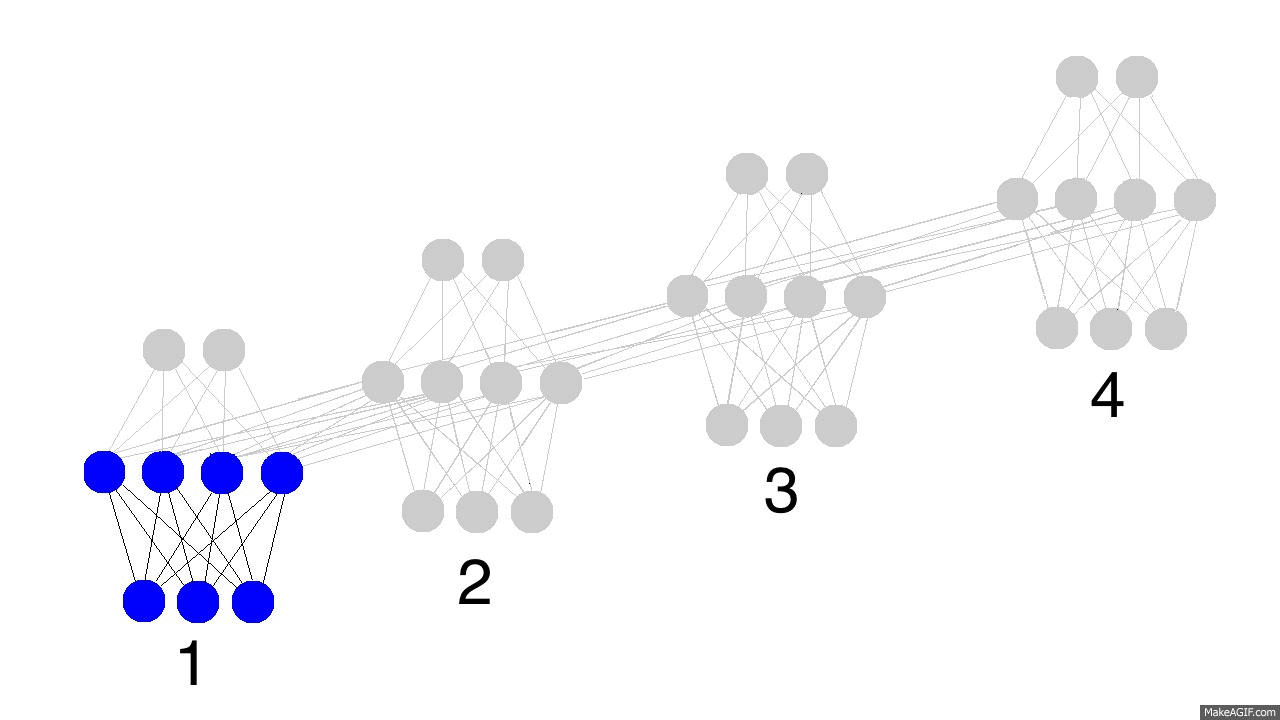
> Sumber gambar: http://iamtrask.github.io/img/recurrence_gif.gif,  https://iamtrask.github.io/2015/11/15/anyone-can-code-lstm/
>
>* Model RNN seolah seperti model ANN dengan dua layer (sebuah hidden layer dan output layer). Hanya saja hidden layer diulang sebanyak time steps melalui variabel sel yang diberi notasi S.
>
>* Di bawah ini model RNN akan di gunakan untuk memecahkan masalah XOR Gate dan juga untuk prediksi harga saham. Kedua contoh sederhana ini sengaja dipilih agar jalan pikiran algoritma untuk RNN mudah dipelajari.
>
>* Harap mahasiswa berkreasi sendiri mencari contoh pemakaian lain untuk menggunakan RNN ini.

___

>* Penurunan matematiknya (terutama backpropagation untuk RNN) bisa dilihat di laman milik Song Huiming berikut: https://songhuiming.github.io/pages/2017/08/20/build-recurrent-neural-network-from-scratch/
>
>* Sekalipun penurunan matematiknya terlihat panjang (sebetulnya hanya aturan rantai dari turunan saja), ternyata bisa terlihat sederhana setelah dituliskan ke dalam  Python code dengan penggunaan looping. Loop yang terpenting ada dua buah. Loop yang pertama untuk menjalankan Stochastic Gradient Descent (SGD) untuk setiap observasi; parameter akan diupdate untuk setiap observasi. Loop kedua dijalankan selama timesteps yang digunakan untuk mengakumulasikan gradients, tanpa ada perubahan parameters.
>
>* Notasi di referensi oleh Song Huiming ini sedikit berbeda dengan kebiasaan kita. Kita terbiasa menggunakan notasi **w0** untuk layer pertama dan **w1** untuk layer kedua. Di referensi itu parameter dituliskan dengan **U,V,W**. Padanan dari **U** adalah **w0** sedangkan padanan dari **V** adalah **w1**. Parameter untuk variabel sel S adalah **W**  dan akan dituliskan menjadi **ws**
___
>* Di referensi semula dituliskan persamaan untuk RNN sebagai berikut: 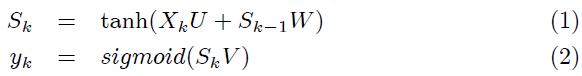
>
>* Parameter U, V, W akan diganti menjadi w0, w1 dan ws: 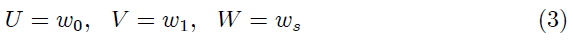
>* Diperoleh persamaan yang kelak akan digunakan di dalam penulisan Python code: 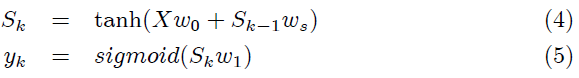
>* Pada Python code di bawah, perhatikan dengan seksama bagaimana variabel S1 dibikin hanya dengan meng-copy A1, sedangkan S2 tidak lain adalah A2.
___

>* Pada ilustrasi berikut, satu-satunya hidden layer yang digunakan di model RNN akan diurai sepanjang time steps: 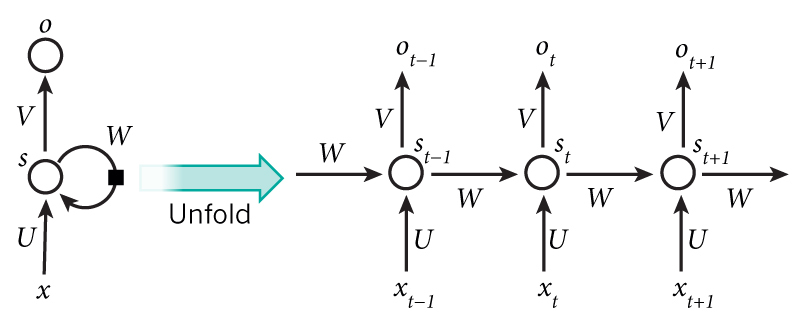
>* Sumber gambar: https://songhuiming.github.io/pages/2017/08/20/build-recurrent-neural-network-from-scratch/

___

>* Harap diperhatikan cara penyajian data yang akan diolah oleh model RNN: data harus merupakan urutan sekuensial. Lihat pembahasan tentang data di awal contoh tentang XOR Gate.

In [1]:
from numpy import *   
import numpy as np
from numpy.random import *
import pandas as pd
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sb
#sb.set_theme()
sb.set_style("whitegrid")
#sb.set_style("darkgrid")

%matplotlib inline

np.set_printoptions(precision = 3, suppress = True, formatter = {'float':'{:6.5f}'.format})

#Sigmoid function & its derivative
sigmoid = lambda Z: 1/(1+exp(-Z))
dsigmoid = lambda A: A*(1-A)

#ReLU function & its derivative
ReLU  = lambda Z: Z.clip(0)
#Derivative of ReLU function
dReLU = lambda A: (A > 0)*1

#Derivativer of tanh()
dtanh = lambda A: 1-A**2

#Derivative oh arctanh
darctanh = lambda A: 1/(A**2+1)

#Softplus function & its derivative
splus = lambda Z: log(1+exp(Z))
dsplus = lambda A: 1/(1+exp(-A))

linear = lambda X,w,b: X@w+b

"Time step (ts)"
def steps(x, step):   
    obs  = len(x)-step
    xt   = x[:obs,:]
    for i in arange(1,step+1):
        xt = hstack((xt, x[i:obs+i,:]))   
    return xt

In [2]:
class RNN:
    def __init__(self,x,nh,alpha,epochs): # ada h nodes di dalam hidden layer  hlayers = [7, 3, 34, 89]
        self.Xtrain  = x #input
        self.ytrain  = x[:,-1:] #output     
        self.nh = nh   #number of neurons in hidden layer
        self.alpha  = alpha
        self.epochs = epochs
        self.Ts = shape(self.Xtrain)[1]-1   # Time-steps
        self.N, no = shape(self.ytrain)     #jumlah observasi (self.N) dan jumlah output
        self.ni    = 1  #jumlah input
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.t = 0
        self.epsilon = 1e-8
        
        self.m_dw1, self.m_dw0, self.m_dws = 0, 0, 0
        self.m_db1, self.m_db0 = 0, 0
        self.v_dw1, self.v_dw0, self.v_dws = 0, 0, 0
        self.v_db1, self.v_db0 = 0, 0
        
        "Initial values untuk parameter w and b"
        seed(20201212)
        self.w0 = randn(self.ni,self.nh)
        self.b0 = randn(1,self.nh)
        self.w1 = randn(self.nh,no)
        self.b1 = randn(1,no)
        self.ws = randn(self.nh,self.nh)
        
    def learning(self):
        self.ycap = []
        for i in range(len(self.Xtrain)):
            self.S1 = [zeros((self.ni, self.nh))]  
            self.S2 = []              
            dCdw0 = zeros_like(self.w0)
            dCdb0 = zeros_like(self.b0)
            dCdw1 = zeros_like(self.w1)
            dCdb1 = zeros_like(self.b1)
            dCdws = zeros_like(self.ws)
            
            "Forward propagation in time step"
            for k in range(self.Ts):       
                A0 = self.Xtrain[i,k]
                yk = self.Xtrain[i,k + 1]
            
                # Forward pass, 1st layer
                Z1 = dot(A0,self.w0) + self.b0 + (self.S1[-1]@self.ws) 
                A1 = tanh(Z1)
                self.S1.append(copy(A1))   
            
                # Forward pass, 2nd layer
                Z2 = A1@self.w1 + self.b1
                A2 = sigmoid(Z2)
                self.S2.append(copy(A2))
                
            self.ycap.append(A2[0])
            
            "Backward propagation in time step"
            for k in arange(self.Ts)[::-1]:     
                A0 = self.Xtrain[i,k]
                yk = self.Xtrain[i,k + 1]
                
                # Backprop, 2nd layer
                dCdZ2 = -(yk - self.S2[k]) * dsigmoid(self.S2[k])
                dCdw1 += dot(self.S1[k+1].T,dCdZ2)
                dCdb1 += sum(dCdZ2)        
            
                # Backprop, 1st layer
                dCdZ1 = dCdZ2@self.w1.T * dtanh(self.S1[k+1])
                dCdw0 += dot(A0, dCdZ1)
                dCdb0 += sum(dCdZ1)
            
                # Backprob, recurrent layer
                dCdws += dot(self.S1[k].T, dCdZ1)
            
            
            "Adam Optimizer"
            self.t = self.t + 1
            
            # first layer
            self.m_dw1 = self.beta1*self.m_dw1 + (1 - self.beta1) * dCdw1
            self.v_dw1 = self.beta2*self.v_dw1 + (1 - self.beta2) * dCdw1**2
            self.m_db1 = self.beta1*self.m_db1 + (1 - self.beta1) * dCdb1
            self.v_db1 = self.beta2*self.v_db1 + (1 - self.beta2) * dCdb1**2
            m_dw1_bias_corr = self.m_dw1 / (1 - self.beta1**self.t)
            m_db1_bias_corr = self.m_db1 / (1 - self.beta1**self.t)
            v_dw1_bias_corr = self.v_dw1 / (1 - self.beta2**self.t)
            v_db1_bias_corr = self.v_db1 / (1 - self.beta2**self.t)
            self.Vw1 = self.alpha * m_dw1_bias_corr / (sqrt(v_dw1_bias_corr) + self.epsilon)
            self.Vb1 = self.alpha * m_db1_bias_corr / (sqrt(v_db1_bias_corr) + self.epsilon)
            
            # second layer
            self.m_dw0 = self.beta1*self.m_dw0 + (1 - self.beta1) * dCdw0
            self.v_dw0 = self.beta2*self.v_dw0 + (1 - self.beta2) * dCdw0**2
            self.m_db0 = self.beta1*self.m_db0 + (1 - self.beta1) * dCdb0
            self.v_db0 = self.beta2*self.v_db0 + (1 - self.beta2) * dCdb0**2
            m_dw0_bias_corr = self.m_dw0 / (1 - self.beta1**self.t)
            m_db0_bias_corr = self.m_db0 / (1 - self.beta1**self.t)
            v_dw0_bias_corr = self.v_dw0 / (1 - self.beta2**self.t)
            v_db0_bias_corr = self.v_db0 / (1 - self.beta2**self.t)
            self.Vw0 = self.alpha * m_dw0_bias_corr / (sqrt(v_dw0_bias_corr) + self.epsilon)
            self.Vb0 = self.alpha * m_db0_bias_corr / (sqrt(v_db0_bias_corr) + self.epsilon)
            
            # output ;ayer
            self.m_dws = self.beta1*self.m_dws + (1 - self.beta1) * dCdws
            self.v_dws = self.beta2*self.v_dws + (1 - self.beta2) * dCdws**2
            m_dws_bias_corr = self.m_dws / (1 - self.beta1**self.t)
            v_dws_bias_corr = self.v_dws / (1 - self.beta2**self.t)
            self.Vws = self.alpha * m_dws_bias_corr / (sqrt(v_dws_bias_corr) + self.epsilon)
            
            # updating parameters
            self.w1 = self.w1 - self.Vw1
            self.b1 = self.b1 - self.Vb1
            self.w0 = self.w0 - self.Vw0
            self.b0 = self.b0 - self.Vb0
            self.ws = self.ws - self.Vws

In [3]:
X = array([(0,0,0), (1,0,0), (0,1,0), (1,1,1)])   #Input
y = array([[0, 1, 1, 0]])   #Output

Xtrain = array([[1,1,1,0], 
                [1,0,0,1], 
                [0,1,0,1], 
                [0,0,0,0]])
ytrain = y

>* Input **X** dan output **y** akan digabung menjadi satu menjadi **Xtrain** dengan output **y** menempati kolom terkahir. Perhatikan bahwa data **Xtrain** inilah yang akan digunakan tapi dengan cara pandang yang berbeda. Kali ini tiap observasi akan dipandang sebagai aliran data di dalam timesteps.

>* Contohnya, observasi pertama [1,1,1,0] akan dipandang sebagai aliran data yang melalui tiga time steps, dengan data (angka) terakhir menunjukkan output yang akan diprediksi oleh RNN pada tahap terakhirnya:   1 -> 1 -> 1 -> 0  (perhatikan, banyaknya panah yang tiga buah ini menunjukkan jumlah timesteps)
>
> Jadi data input **X** dan output **y** secara keseluruhan telah dikemas di dalam **Xtrain** dan akan dipandang sebagai aliran data dengan masing-masing observasi mempunyai tiga buah anak panah yang menunjukkan banyaknya time steps
>
>* 1 -> 1 -> 1 -> 0
>* 1 -> 0 -> 0 -> 1
>* 0 -> 1 -> 0 -> 1
>* 0 -> 0 -> 0 -> 0
>
>Hanya data yang sudah terurut secara sekuensial seperti **Xtrain** inilah yang bisa digunakan di model RNN.

#### Contoh #1: Pemakaian RNN untuk memecahkan masalah XOR Gate

In [4]:
nh     = 3  
alpha  = 1
epochs = 501

"Training"

rnn1 = RNN(Xtrain,nh,alpha,epochs)
tic = datetime.now()

for n in range(epochs):
    rnn1.learning()
    e = rnn1.ycap - ytrain
    sse = dot(e.T,e)/len(ytrain)
    toc = datetime.now()
            
    if n % ((epochs-1)/5) == 0:
        print(f"\nPada epoch ke {n} diperoleh predicted vs actual:")
        print(hstack((array(rnn1.ycap), ytrain.reshape(4,1))))


Pada epoch ke 0 diperoleh predicted vs actual:
[[0.30800 0.00000]
 [0.39343 1.00000]
 [0.32170 1.00000]
 [0.80890 0.00000]]

Pada epoch ke 100 diperoleh predicted vs actual:
[[0.38627 0.00000]
 [0.39882 1.00000]
 [0.39013 1.00000]
 [0.46796 0.00000]]

Pada epoch ke 200 diperoleh predicted vs actual:
[[0.38295 0.00000]
 [0.39243 1.00000]
 [0.38518 1.00000]
 [0.46364 0.00000]]

Pada epoch ke 300 diperoleh predicted vs actual:
[[0.37143 0.00000]
 [0.36549 1.00000]
 [0.35836 1.00000]
 [0.44074 0.00000]]

Pada epoch ke 400 diperoleh predicted vs actual:
[[0.36908 0.00000]
 [0.36351 1.00000]
 [0.35691 1.00000]
 [0.43918 0.00000]]

Pada epoch ke 500 diperoleh predicted vs actual:
[[0.36661 0.00000]
 [0.36160 1.00000]
 [0.35576 1.00000]
 [0.43715 0.00000]]


#### Contoh #2: Pemakaian RNN untuk penaksiran harga saham

___

>Pada contoh akan terlihat bahwa upaya pemodelan pergerakan harga untuk prediksi ternyata menghasilkan model yang sangat sederhana. Kali ini timestep yang cocok sebesar 1, timestep yang lain tidak cocok. Ini artinya hanya data hari ini yang perlu digunakan untuk memprediksi harga saham esok hari. 
>
>Demikian pula jumlah neurons yang perlu digunakan untuk hidden layer ternyata hanya diperlukan tiga buah.  Lagi-lagi ini memperlihatkan bahwa model yang cocok untuk memodelkan pergerakan harga saham ternyata model yang sederhana. Ini seperti hasil yang telah diperoleh sebelumnya ketika pembahasan pada Multi Layer Perceptron.
>
>Karena itu untuk sementara akan dihipotesakan bahwa siapa saja yang berusaha membuat model yang kompleks untuk pergerakan harga saham maka hasilnya akan semakin tidak bagus.

In [11]:
A  = pd.read_csv('HPE.csv')  #Data time series harian harga saham Bank Mandiri sejak 02 Januari 2015
A6 = A['Adj Close'].values   #Ambil kolom ke enam berisi 'Adj Close', 
B  = A6[:,newaxis]  
                                     
Bmin = min(B)
Bmax = max(B)
b = (B-Bmin)/(Bmax-Bmin)

ts = 1   #Di literatur Time Series digunakan istilah 'lag' sebagai padanan istilah 'timestep' ini
xs = steps(b, ts)  #Dihasilkan matriks dengan 2 (= ts+1) kolom, kolom pertama menjadi variabel X
                   #dan kolom terkhir menjadi variabel 
x = xs[-800:,:]    #Ambil 800 observasi terakhir

#Data untuk training
Xtrain = x[0:680,:]   #Ambil 680 observasi yang pertama dan hilangkan kolom terakhir
ytrain = x[0:680:, -1:]  #Ambil 680 observasi yang pertama dan ambil kolom terakhir sebagai variabel y 

#Data untuk testing
Xtest = x[680:, :]   #ambil jumlah observasi sebanyak 120, hilangkan kolom terakhir (untuk y)
ytest = x[680:, -1:] #ambil kolom terakhir

#plt.plot(Xtrain, color = 'b')
#plt.show()

Epoch ke 0, SSE sebesar: 0.00547 dalam waktu 0:00:00.627350
Epoch ke 7, SSE sebesar: 0.00601 dalam waktu 0:00:04.488706
Epoch ke 14, SSE sebesar: 0.00601 dalam waktu 0:00:08.343308
Epoch ke 21, SSE sebesar: 0.00601 dalam waktu 0:00:11.217859
Epoch ke 28, SSE sebesar: 0.00601 dalam waktu 0:00:13.993975
Epoch ke 35, SSE sebesar: 0.00601 dalam waktu 0:00:17.556511


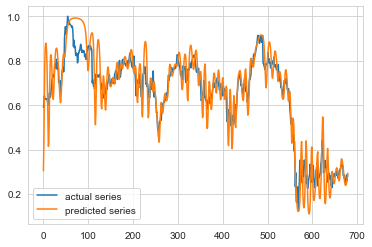

In [12]:
#Ringkasan nh = 3, alpha = 0.27 epochs = 36, ts = 1

nh     = 3  
alpha  = 0.27
epochs = 36

"Training"

rnn2 = RNN(Xtrain,nh,alpha,epochs)
tic = datetime.now()

for n in range(epochs):
    rnn2.learning()
    e = rnn2.ycap - ytrain
    sse = dot(e.T,e)/len(ytrain)
    toc = datetime.now()
            
    if n % ((epochs-1)/5) == 0:
        #print(f"\nPada epoch ke {n} diperoleh predicted vs actual:")
        #print(hstack((array(rnn2.ycap), ytrain.reshape(4,1))))
        print(f"Epoch ke {n}, SSE sebesar: {sse[0][0]:6.5f} dalam waktu {datetime.now()-tic}")

#rnn = RNN(Xtrain,nh,alpha,epochs)
#rnn.training()
# ytrainhat = rnn2.ycap
# ytrain    = ytrain*(Bmax-Bmin)+Bmin      #Kembalikan datanya ke original unit dalam satuan dolar
# ytrainhat = ytrainhat*(Bmax-Bmin)+Bmin   #Kembalikan datanya ke original unit dalam satuan dolar

plt.plot(ytrain, label = 'actual series')
plt.plot(rnn2.ycap, label = 'predicted series')
plt.legend()
plt.show()

#### Test the model

MSE training: 0.0060094 
MSE testing : 0.0309694


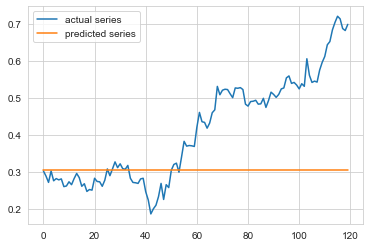

In [13]:
ytestcap = []

for i in range(len(Xtest)):
    S1 = [zeros((1, nh))]  
    S2 = []              
            
    "Forward propagation in time step"
    for k in range(rnn2.Ts):       
        A0 = Xtest[i,k]
        yk = Xtest[i,k + 1]
            
        # Forward pass, 1st layer
        Z1 = dot(A0,rnn2.w0) + rnn2.b0 + (S1[-1]@rnn2.ws) 
        A1 = tanh(Z1)
        S1.append(copy(A1))   
            
        # Forward pass, 2nd layer
        Z2 = A1@rnn2.w1 + rnn2.b1
        A2 = sigmoid(Z2)
        rnn2.S2.append(copy(A2))
                
    ytestcap.append(A2[0])

e = ytestcap - ytest
ssetest = dot(e.T,e)/len(ytest)
print('MSE training: %8.7f'%sse,'\nMSE testing : %7.7f'%ssetest)
      
plt.plot(ytest, label = 'actual series')
plt.plot(ytestcap, label = 'predicted series')
plt.legend()
plt.show()